Convolutional Dictionary Learning with Spatial Mask
===================================================

This example demonstrates the use of [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn) for convolutional dictionary learning with a spatial mask, from a set of greyscale training images. The dictionary learning algorithm is based on the hybrid mask decoupling / ADMM consensus dictionary update [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2017-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.25, gray=True)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S = np.dstack((S1, S2))

Construct initial dictionary.

In [3]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 32)

Create random mask and apply to training images.

In [4]:
frc = 0.5
W = util.rndmask(S.shape[0:2] + (1,), frc, dtype=np.float32)
Sw = W * S

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter.

In [5]:
lmbda = 0.1
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
            'DFidWeight': W, 'gEvalY': False, 'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(Sw, lmbda, opt)
sl = b.solve()
sh = Sw - sl

CDL without a spatial mask using [admm.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNDictLearn).

In [6]:
lmbda = 0.05
opt1 = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'rho': 1e2}})
d1 = cbpdndl.ConvBPDNDictLearn(D0, sh, lmbda, opt1)
D1 = d1.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  5.79e+02  4.09e+02  3.39e+03  5.31e-07  5.48e-01  6.85e-01  3.00e+00  9.16e-02  1.22e-01  1.00e+02
   1  3.92e+02  5.62e+01  6.72e+03  4.18e-07  2.72e-01  7.51e-01  3.00e+00  1.27e-01  2.78e-01  1.00e+02


   2  3.20e+02  2.11e+01  5.99e+03  4.92e-07  2.00e-01  4.32e-01  3.00e+00  6.61e-02  2.08e-01  1.00e+02
   3  2.75e+02  2.99e+01  4.91e+03  5.09e-07  1.57e-01  4.08e-01  3.00e+00  6.76e-02  1.47e-01  1.00e+02


   4  2.81e+02  4.31e+01  4.75e+03  4.52e-07  1.25e-01  2.53e-01  3.00e+00  4.01e-02  1.41e-01  1.00e+02
   5  2.77e+02  2.54e+01  5.03e+03  4.93e-07  9.05e-02  2.36e-01  3.00e+00  3.18e-02  1.18e-01  1.00e+02


   6  2.72e+02  8.12e+00  5.29e+03  5.83e-07  7.22e-02  2.23e-01  3.00e+00  2.76e-02  1.11e-01  1.00e+02
   7  2.64e+02  5.51e+00  5.17e+03  5.22e-07  6.19e-02  1.97e-01  3.00e+00  1.95e-02  1.04e-01  1.00e+02


   8  2.58e+02  1.52e+01  4.86e+03  5.63e-07  5.26e-02  2.05e-01  3.00e+00  2.04e-02  1.04e-01  1.00e+02
   9  2.60e+02  2.39e+01  4.71e+03  5.39e-07  4.56e-02  1.59e-01  3.00e+00  1.64e-02  9.90e-02  1.00e+02


  10  2.58e+02  1.80e+01  4.80e+03  3.97e-07  3.82e-02  1.47e-01  3.00e+00  1.17e-02  8.30e-02  1.00e+02
  11  2.57e+02  1.08e+01  4.93e+03  4.80e-07  3.27e-02  1.47e-01  3.00e+00  1.14e-02  7.29e-02  1.00e+02


  12  2.56e+02  8.99e+00  4.93e+03  5.10e-07  2.89e-02  1.32e-01  3.00e+00  8.62e-03  6.64e-02  1.00e+02
  13  2.53e+02  1.11e+01  4.84e+03  4.89e-07  2.53e-02  1.29e-01  3.00e+00  7.57e-03  6.46e-02  1.00e+02


  14  2.52e+02  1.41e+01  4.76e+03  3.56e-07  2.28e-02  1.21e-01  3.00e+00  7.56e-03  6.49e-02  1.00e+02
  15  2.52e+02  1.49e+01  4.74e+03  5.02e-07  2.07e-02  1.10e-01  3.00e+00  6.20e-03  6.09e-02  1.00e+02


  16  2.52e+02  1.35e+01  4.77e+03  5.09e-07  1.88e-02  1.06e-01  3.00e+00  5.15e-03  5.58e-02  1.00e+02
  17  2.52e+02  1.15e+01  4.80e+03  5.99e-07  1.73e-02  1.02e-01  3.00e+00  4.85e-03  5.22e-02  1.00e+02


  18  2.51e+02  1.07e+01  4.80e+03  5.15e-07  1.62e-02  9.79e-02  3.00e+00  4.31e-03  4.97e-02  1.00e+02
  19  2.50e+02  1.13e+01  4.78e+03  4.83e-07  1.51e-02  9.48e-02  3.00e+00  4.05e-03  4.80e-02  1.00e+02


  20  2.50e+02  1.24e+01  4.74e+03  5.64e-07  1.41e-02  9.13e-02  3.00e+00  4.06e-03  4.70e-02  1.00e+02
  21  2.49e+02  1.29e+01  4.73e+03  3.86e-07  1.33e-02  8.67e-02  3.00e+00  3.76e-03  4.55e-02  1.00e+02


  22  2.49e+02  1.24e+01  4.73e+03  5.48e-07  1.26e-02  8.36e-02  3.00e+00  3.37e-03  4.37e-02  1.00e+02
  23  2.49e+02  1.16e+01  4.74e+03  4.79e-07  1.20e-02  8.14e-02  3.00e+00  3.19e-03  4.20e-02  1.00e+02


  24  2.49e+02  1.13e+01  4.75e+03  4.52e-07  1.14e-02  7.90e-02  3.00e+00  3.03e-03  4.06e-02  1.00e+02
  25  2.48e+02  1.14e+01  4.74e+03  4.90e-07  1.09e-02  7.68e-02  3.00e+00  2.93e-03  3.94e-02  1.00e+02


  26  2.48e+02  1.18e+01  4.72e+03  4.23e-07  1.04e-02  7.46e-02  3.00e+00  2.88e-03  3.83e-02  1.00e+02
  27  2.48e+02  1.20e+01  4.72e+03  4.64e-07  9.97e-03  7.22e-02  3.00e+00  2.79e-03  3.73e-02  1.00e+02
  28  2.48e+02  1.19e+01  4.72e+03  5.08e-07  9.57e-03  7.01e-02  3.00e+00  2.64e-03  3.63e-02  1.00e+02


  29  2.48e+02  1.16e+01  4.72e+03  5.56e-07  9.21e-03  6.84e-02  3.00e+00  2.53e-03  3.54e-02  1.00e+02
  30  2.47e+02  1.14e+01  4.72e+03  5.00e-07  8.88e-03  6.67e-02  3.00e+00  2.45e-03  3.45e-02  1.00e+02
  31  2.47e+02  1.14e+01  4.72e+03  4.87e-07  8.57e-03  6.51e-02  3.00e+00  2.39e-03  3.36e-02  1.00e+02


  32  2.47e+02  1.15e+01  4.71e+03  5.05e-07  8.27e-03  6.35e-02  3.00e+00  2.34e-03  3.29e-02  1.00e+02
  33  2.47e+02  1.16e+01  4.71e+03  4.49e-07  8.00e-03  6.20e-02  3.00e+00  2.29e-03  3.22e-02  1.00e+02
  34  2.47e+02  1.16e+01  4.70e+03  5.44e-07  7.75e-03  6.04e-02  3.00e+00  2.23e-03  3.17e-02  1.00e+02


  35  2.47e+02  1.15e+01  4.70e+03  5.53e-07  7.51e-03  5.91e-02  3.00e+00  2.17e-03  3.11e-02  1.00e+02
  36  2.46e+02  1.14e+01  4.70e+03  5.46e-07  7.29e-03  5.79e-02  3.00e+00  2.11e-03  3.05e-02  1.00e+02
  37  2.46e+02  1.14e+01  4.70e+03  6.25e-07  7.09e-03  5.67e-02  3.00e+00  2.06e-03  3.00e-02  1.00e+02


  38  2.46e+02  1.14e+01  4.70e+03  4.44e-07  6.90e-03  5.57e-02  3.00e+00  2.02e-03  2.95e-02  1.00e+02
  39  2.46e+02  1.14e+01  4.69e+03  4.77e-07  6.72e-03  5.46e-02  3.00e+00  1.98e-03  2.89e-02  1.00e+02
  40  2.46e+02  1.14e+01  4.69e+03  3.88e-07  6.54e-03  5.36e-02  3.00e+00  1.94e-03  2.84e-02  1.00e+02


  41  2.46e+02  1.14e+01  4.69e+03  3.77e-07  6.37e-03  5.25e-02  3.00e+00  1.90e-03  2.79e-02  1.00e+02
  42  2.46e+02  1.13e+01  4.69e+03  5.04e-07  6.22e-03  5.16e-02  3.00e+00  1.87e-03  2.75e-02  1.00e+02
  43  2.46e+02  1.13e+01  4.69e+03  3.91e-07  6.07e-03  5.06e-02  3.00e+00  1.84e-03  2.70e-02  1.00e+02


  44  2.46e+02  1.13e+01  4.69e+03  5.21e-07  5.93e-03  4.97e-02  3.00e+00  1.81e-03  2.66e-02  1.00e+02
  45  2.46e+02  1.13e+01  4.69e+03  5.53e-07  5.79e-03  4.88e-02  3.00e+00  1.78e-03  2.61e-02  1.00e+02
  46  2.45e+02  1.13e+01  4.68e+03  5.45e-07  5.66e-03  4.79e-02  3.00e+00  1.75e-03  2.57e-02  1.00e+02


  47  2.45e+02  1.13e+01  4.68e+03  4.51e-07  5.53e-03  4.71e-02  3.00e+00  1.73e-03  2.53e-02  1.00e+02
  48  2.45e+02  1.12e+01  4.68e+03  4.82e-07  5.41e-03  4.63e-02  3.00e+00  1.70e-03  2.50e-02  1.00e+02
  49  2.45e+02  1.12e+01  4.68e+03  4.81e-07  5.29e-03  4.55e-02  3.00e+00  1.67e-03  2.47e-02  1.00e+02


  50  2.45e+02  1.12e+01  4.68e+03  4.63e-07  5.19e-03  4.48e-02  3.00e+00  1.65e-03  2.44e-02  1.00e+02
  51  2.45e+02  1.12e+01  4.68e+03  4.72e-07  5.08e-03  4.42e-02  3.00e+00  1.63e-03  2.41e-02  1.00e+02
  52  2.45e+02  1.12e+01  4.68e+03  3.78e-07  4.99e-03  4.35e-02  3.00e+00  1.61e-03  2.38e-02  1.00e+02


  53  2.45e+02  1.12e+01  4.67e+03  5.90e-07  4.89e-03  4.29e-02  3.00e+00  1.59e-03  2.35e-02  1.00e+02
  54  2.45e+02  1.12e+01  4.67e+03  5.06e-07  4.81e-03  4.23e-02  3.00e+00  1.57e-03  2.32e-02  1.00e+02
  55  2.45e+02  1.12e+01  4.67e+03  4.72e-07  4.72e-03  4.18e-02  3.00e+00  1.55e-03  2.29e-02  1.00e+02


  56  2.45e+02  1.11e+01  4.67e+03  3.64e-07  4.64e-03  4.12e-02  3.00e+00  1.53e-03  2.26e-02  1.00e+02
  57  2.45e+02  1.11e+01  4.67e+03  5.70e-07  4.56e-03  4.06e-02  3.00e+00  1.51e-03  2.23e-02  1.00e+02
  58  2.44e+02  1.11e+01  4.67e+03  4.93e-07  4.49e-03  4.01e-02  3.00e+00  1.50e-03  2.20e-02  1.00e+02


  59  2.44e+02  1.11e+01  4.67e+03  3.86e-07  4.41e-03  3.96e-02  3.00e+00  1.49e-03  2.18e-02  1.00e+02
  60  2.44e+02  1.11e+01  4.66e+03  4.78e-07  4.35e-03  3.90e-02  3.00e+00  1.47e-03  2.16e-02  1.00e+02
  61  2.44e+02  1.11e+01  4.66e+03  4.95e-07  4.28e-03  3.85e-02  3.00e+00  1.46e-03  2.13e-02  1.00e+02


  62  2.44e+02  1.10e+01  4.66e+03  5.03e-07  4.21e-03  3.81e-02  3.00e+00  1.44e-03  2.12e-02  1.00e+02
  63  2.44e+02  1.10e+01  4.66e+03  4.94e-07  4.15e-03  3.76e-02  3.00e+00  1.43e-03  2.10e-02  1.00e+02
  64  2.44e+02  1.10e+01  4.66e+03  6.64e-07  4.09e-03  3.72e-02  3.00e+00  1.42e-03  2.08e-02  1.00e+02


  65  2.44e+02  1.10e+01  4.65e+03  6.19e-07  4.04e-03  3.68e-02  3.00e+00  1.40e-03  2.07e-02  1.00e+02
  66  2.44e+02  1.10e+01  4.65e+03  4.49e-07  3.98e-03  3.64e-02  3.00e+00  1.39e-03  2.05e-02  1.00e+02
  67  2.43e+02  1.10e+01  4.65e+03  5.03e-07  3.93e-03  3.61e-02  3.00e+00  1.38e-03  2.04e-02  1.00e+02


  68  2.43e+02  1.09e+01  4.65e+03  5.79e-07  3.88e-03  3.57e-02  3.00e+00  1.38e-03  2.02e-02  1.00e+02
  69  2.43e+02  1.09e+01  4.65e+03  4.91e-07  3.83e-03  3.53e-02  3.00e+00  1.36e-03  2.00e-02  1.00e+02
  70  2.43e+02  1.09e+01  4.64e+03  5.36e-07  3.78e-03  3.50e-02  3.00e+00  1.35e-03  1.98e-02  1.00e+02


  71  2.43e+02  1.09e+01  4.64e+03  5.02e-07  3.74e-03  3.46e-02  3.00e+00  1.34e-03  1.97e-02  1.00e+02
  72  2.43e+02  1.09e+01  4.64e+03  3.99e-07  3.69e-03  3.43e-02  3.00e+00  1.34e-03  1.95e-02  1.00e+02
  73  2.43e+02  1.08e+01  4.64e+03  5.47e-07  3.65e-03  3.39e-02  3.00e+00  1.32e-03  1.93e-02  1.00e+02


  74  2.43e+02  1.08e+01  4.64e+03  4.72e-07  3.61e-03  3.36e-02  3.00e+00  1.31e-03  1.91e-02  1.00e+02
  75  2.42e+02  1.08e+01  4.63e+03  6.07e-07  3.57e-03  3.33e-02  3.00e+00  1.30e-03  1.90e-02  1.00e+02
  76  2.42e+02  1.08e+01  4.63e+03  4.32e-07  3.53e-03  3.30e-02  3.00e+00  1.30e-03  1.88e-02  1.00e+02


  77  2.42e+02  1.08e+01  4.63e+03  5.29e-07  3.49e-03  3.27e-02  3.00e+00  1.29e-03  1.87e-02  1.00e+02
  78  2.42e+02  1.07e+01  4.62e+03  4.67e-07  3.45e-03  3.24e-02  3.00e+00  1.28e-03  1.85e-02  1.00e+02
  79  2.42e+02  1.07e+01  4.62e+03  5.90e-07  3.42e-03  3.21e-02  3.00e+00  1.28e-03  1.84e-02  1.00e+02


  80  2.42e+02  1.07e+01  4.62e+03  5.98e-07  3.38e-03  3.18e-02  3.00e+00  1.27e-03  1.83e-02  1.00e+02
  81  2.41e+02  1.07e+01  4.62e+03  4.79e-07  3.35e-03  3.15e-02  3.00e+00  1.26e-03  1.81e-02  1.00e+02
  82  2.41e+02  1.06e+01  4.61e+03  4.57e-07  3.31e-03  3.12e-02  3.00e+00  1.26e-03  1.80e-02  1.00e+02


  83  2.41e+02  1.06e+01  4.61e+03  4.48e-07  3.28e-03  3.10e-02  3.00e+00  1.25e-03  1.79e-02  1.00e+02
  84  2.41e+02  1.06e+01  4.61e+03  5.24e-07  3.25e-03  3.07e-02  3.00e+00  1.25e-03  1.77e-02  1.00e+02
  85  2.41e+02  1.06e+01  4.60e+03  5.26e-07  3.22e-03  3.04e-02  3.00e+00  1.24e-03  1.76e-02  1.00e+02


  86  2.41e+02  1.06e+01  4.60e+03  5.35e-07  3.19e-03  3.01e-02  3.00e+00  1.23e-03  1.75e-02  1.00e+02
  87  2.40e+02  1.05e+01  4.60e+03  4.77e-07  3.15e-03  2.98e-02  3.00e+00  1.23e-03  1.74e-02  1.00e+02
  88  2.40e+02  1.05e+01  4.59e+03  5.36e-07  3.12e-03  2.96e-02  3.00e+00  1.23e-03  1.73e-02  1.00e+02


  89  2.40e+02  1.05e+01  4.59e+03  5.20e-07  3.09e-03  2.93e-02  3.00e+00  1.21e-03  1.71e-02  1.00e+02
  90  2.40e+02  1.05e+01  4.59e+03  6.29e-07  3.07e-03  2.91e-02  3.00e+00  1.21e-03  1.70e-02  1.00e+02
  91  2.40e+02  1.05e+01  4.58e+03  4.85e-07  3.04e-03  2.89e-02  3.00e+00  1.20e-03  1.69e-02  1.00e+02


  92  2.39e+02  1.04e+01  4.58e+03  5.40e-07  3.01e-03  2.86e-02  3.00e+00  1.20e-03  1.68e-02  1.00e+02
  93  2.39e+02  1.04e+01  4.58e+03  5.24e-07  2.98e-03  2.84e-02  3.00e+00  1.19e-03  1.67e-02  1.00e+02
  94  2.39e+02  1.04e+01  4.57e+03  4.64e-07  2.96e-03  2.82e-02  3.00e+00  1.18e-03  1.66e-02  1.00e+02


  95  2.39e+02  1.04e+01  4.57e+03  5.18e-07  2.93e-03  2.79e-02  3.00e+00  1.18e-03  1.65e-02  1.00e+02
  96  2.39e+02  1.04e+01  4.57e+03  6.03e-07  2.91e-03  2.77e-02  3.00e+00  1.18e-03  1.64e-02  1.00e+02
  97  2.38e+02  1.03e+01  4.56e+03  5.17e-07  2.88e-03  2.76e-02  3.00e+00  1.17e-03  1.63e-02  1.00e+02


  98  2.38e+02  1.03e+01  4.56e+03  4.85e-07  2.86e-03  2.74e-02  3.00e+00  1.16e-03  1.62e-02  1.00e+02
  99  2.38e+02  1.03e+01  4.56e+03  4.82e-07  2.84e-03  2.72e-02  3.00e+00  1.15e-03  1.61e-02  1.00e+02
 100  2.38e+02  1.03e+01  4.55e+03  5.70e-07  2.82e-03  2.70e-02  3.00e+00  1.15e-03  1.60e-02  1.00e+02


 101  2.38e+02  1.03e+01  4.55e+03  6.09e-07  2.80e-03  2.69e-02  3.00e+00  1.15e-03  1.59e-02  1.00e+02
 102  2.38e+02  1.02e+01  4.55e+03  4.49e-07  2.78e-03  2.67e-02  3.00e+00  1.14e-03  1.58e-02  1.00e+02
 103  2.37e+02  1.02e+01  4.54e+03  5.27e-07  2.76e-03  2.65e-02  3.00e+00  1.14e-03  1.57e-02  1.00e+02


 104  2.37e+02  1.02e+01  4.54e+03  4.62e-07  2.75e-03  2.64e-02  3.00e+00  1.13e-03  1.56e-02  1.00e+02
 105  2.37e+02  1.02e+01  4.53e+03  5.47e-07  2.73e-03  2.62e-02  3.00e+00  1.13e-03  1.55e-02  1.00e+02
 106  2.37e+02  1.02e+01  4.53e+03  6.02e-07  2.71e-03  2.61e-02  3.00e+00  1.12e-03  1.54e-02  1.00e+02


 107  2.37e+02  1.01e+01  4.53e+03  5.86e-07  2.70e-03  2.60e-02  3.00e+00  1.12e-03  1.53e-02  1.00e+02
 108  2.36e+02  1.01e+01  4.52e+03  4.84e-07  2.68e-03  2.58e-02  3.00e+00  1.11e-03  1.52e-02  1.00e+02
 109  2.36e+02  1.01e+01  4.52e+03  4.26e-07  2.67e-03  2.57e-02  3.00e+00  1.11e-03  1.51e-02  1.00e+02


 110  2.36e+02  1.01e+01  4.52e+03  5.37e-07  2.66e-03  2.56e-02  3.00e+00  1.11e-03  1.50e-02  1.00e+02
 111  2.36e+02  1.01e+01  4.51e+03  4.99e-07  2.64e-03  2.55e-02  3.00e+00  1.11e-03  1.50e-02  1.00e+02
 112  2.35e+02  1.00e+01  4.51e+03  5.20e-07  2.63e-03  2.54e-02  3.00e+00  1.11e-03  1.49e-02  1.00e+02


 113  2.35e+02  1.00e+01  4.50e+03  5.19e-07  2.62e-03  2.53e-02  3.00e+00  1.10e-03  1.48e-02  1.00e+02
 114  2.35e+02  1.00e+01  4.50e+03  5.60e-07  2.61e-03  2.53e-02  3.00e+00  1.10e-03  1.47e-02  1.00e+02
 115  2.35e+02  9.98e+00  4.50e+03  4.90e-07  2.60e-03  2.52e-02  3.00e+00  1.10e-03  1.47e-02  1.00e+02


 116  2.35e+02  9.96e+00  4.49e+03  6.49e-07  2.60e-03  2.51e-02  3.00e+00  1.09e-03  1.46e-02  1.00e+02
 117  2.34e+02  9.93e+00  4.49e+03  5.47e-07  2.59e-03  2.51e-02  3.00e+00  1.09e-03  1.45e-02  1.00e+02
 118  2.34e+02  9.89e+00  4.48e+03  4.49e-07  2.58e-03  2.50e-02  3.00e+00  1.09e-03  1.45e-02  1.00e+02


 119  2.34e+02  9.87e+00  4.48e+03  5.39e-07  2.58e-03  2.50e-02  3.00e+00  1.08e-03  1.44e-02  1.00e+02
 120  2.34e+02  9.85e+00  4.47e+03  4.21e-07  2.57e-03  2.49e-02  3.00e+00  1.08e-03  1.43e-02  1.00e+02
 121  2.33e+02  9.83e+00  4.47e+03  5.40e-07  2.57e-03  2.49e-02  3.00e+00  1.09e-03  1.43e-02  1.00e+02


 122  2.33e+02  9.81e+00  4.47e+03  4.57e-07  2.57e-03  2.48e-02  3.00e+00  1.08e-03  1.42e-02  1.00e+02
 123  2.33e+02  9.79e+00  4.46e+03  4.85e-07  2.56e-03  2.47e-02  3.00e+00  1.08e-03  1.41e-02  1.00e+02
 124  2.33e+02  9.76e+00  4.46e+03  6.92e-07  2.55e-03  2.47e-02  3.00e+00  1.08e-03  1.41e-02  1.00e+02


 125  2.32e+02  9.74e+00  4.45e+03  4.91e-07  2.55e-03  2.46e-02  3.00e+00  1.08e-03  1.40e-02  1.00e+02
 126  2.32e+02  9.71e+00  4.45e+03  4.44e-07  2.54e-03  2.46e-02  3.00e+00  1.07e-03  1.39e-02  1.00e+02
 127  2.32e+02  9.68e+00  4.44e+03  4.87e-07  2.54e-03  2.46e-02  3.00e+00  1.08e-03  1.38e-02  1.00e+02


 128  2.32e+02  9.66e+00  4.44e+03  4.21e-07  2.54e-03  2.45e-02  3.00e+00  1.07e-03  1.38e-02  1.00e+02
 129  2.31e+02  9.65e+00  4.43e+03  5.16e-07  2.54e-03  2.45e-02  3.00e+00  1.07e-03  1.37e-02  1.00e+02
 130  2.31e+02  9.62e+00  4.43e+03  6.08e-07  2.54e-03  2.45e-02  3.00e+00  1.07e-03  1.37e-02  1.00e+02


 131  2.31e+02  9.60e+00  4.42e+03  5.44e-07  2.53e-03  2.44e-02  3.00e+00  1.07e-03  1.36e-02  1.00e+02
 132  2.31e+02  9.57e+00  4.42e+03  4.94e-07  2.53e-03  2.44e-02  3.00e+00  1.07e-03  1.35e-02  1.00e+02


 133  2.30e+02  9.55e+00  4.41e+03  5.17e-07  2.53e-03  2.44e-02  3.00e+00  1.06e-03  1.35e-02  1.00e+02
 134  2.30e+02  9.53e+00  4.41e+03  4.39e-07  2.53e-03  2.44e-02  3.00e+00  1.07e-03  1.34e-02  1.00e+02


 135  2.30e+02  9.51e+00  4.40e+03  4.54e-07  2.53e-03  2.44e-02  3.00e+00  1.06e-03  1.34e-02  1.00e+02
 136  2.29e+02  9.49e+00  4.40e+03  5.26e-07  2.53e-03  2.44e-02  3.00e+00  1.06e-03  1.33e-02  1.00e+02


 137  2.29e+02  9.46e+00  4.39e+03  4.81e-07  2.54e-03  2.44e-02  3.00e+00  1.07e-03  1.33e-02  1.00e+02
 138  2.29e+02  9.44e+00  4.39e+03  5.12e-07  2.54e-03  2.44e-02  3.00e+00  1.07e-03  1.32e-02  1.00e+02


 139  2.29e+02  9.42e+00  4.38e+03  4.18e-07  2.54e-03  2.44e-02  3.00e+00  1.07e-03  1.32e-02  1.00e+02
 140  2.28e+02  9.40e+00  4.38e+03  4.07e-07  2.54e-03  2.44e-02  3.00e+00  1.07e-03  1.32e-02  1.00e+02


 141  2.28e+02  9.38e+00  4.37e+03  5.08e-07  2.54e-03  2.44e-02  3.00e+00  1.07e-03  1.31e-02  1.00e+02
 142  2.28e+02  9.35e+00  4.37e+03  4.50e-07  2.55e-03  2.44e-02  3.00e+00  1.07e-03  1.31e-02  1.00e+02


 143  2.27e+02  9.33e+00  4.36e+03  6.07e-07  2.55e-03  2.44e-02  3.00e+00  1.07e-03  1.30e-02  1.00e+02
 144  2.27e+02  9.31e+00  4.36e+03  5.64e-07  2.55e-03  2.44e-02  3.00e+00  1.07e-03  1.30e-02  1.00e+02


 145  2.27e+02  9.29e+00  4.35e+03  5.79e-07  2.55e-03  2.45e-02  3.00e+00  1.07e-03  1.29e-02  1.00e+02
 146  2.27e+02  9.27e+00  4.35e+03  5.51e-07  2.56e-03  2.45e-02  3.00e+00  1.07e-03  1.29e-02  1.00e+02


 147  2.26e+02  9.24e+00  4.34e+03  6.04e-07  2.56e-03  2.45e-02  3.00e+00  1.07e-03  1.29e-02  1.00e+02
 148  2.26e+02  9.22e+00  4.34e+03  4.29e-07  2.57e-03  2.45e-02  3.00e+00  1.07e-03  1.28e-02  1.00e+02


 149  2.26e+02  9.20e+00  4.33e+03  5.05e-07  2.57e-03  2.46e-02  3.00e+00  1.07e-03  1.28e-02  1.00e+02
 150  2.25e+02  9.18e+00  4.33e+03  5.13e-07  2.58e-03  2.46e-02  3.00e+00  1.07e-03  1.27e-02  1.00e+02
 151  2.25e+02  9.16e+00  4.32e+03  4.75e-07  2.59e-03  2.47e-02  3.00e+00  1.07e-03  1.27e-02  1.00e+02


 152  2.25e+02  9.14e+00  4.32e+03  4.66e-07  2.59e-03  2.47e-02  3.00e+00  1.07e-03  1.26e-02  1.00e+02
 153  2.25e+02  9.11e+00  4.31e+03  4.62e-07  2.60e-03  2.48e-02  3.00e+00  1.07e-03  1.26e-02  1.00e+02
 154  2.24e+02  9.08e+00  4.30e+03  4.96e-07  2.61e-03  2.48e-02  3.00e+00  1.07e-03  1.26e-02  1.00e+02


 155  2.24e+02  9.07e+00  4.30e+03  4.35e-07  2.61e-03  2.49e-02  3.00e+00  1.07e-03  1.25e-02  1.00e+02
 156  2.24e+02  9.05e+00  4.29e+03  5.37e-07  2.62e-03  2.49e-02  3.00e+00  1.07e-03  1.25e-02  1.00e+02
 157  2.23e+02  9.03e+00  4.29e+03  5.43e-07  2.63e-03  2.49e-02  3.00e+00  1.08e-03  1.25e-02  1.00e+02


 158  2.23e+02  9.00e+00  4.28e+03  5.55e-07  2.63e-03  2.49e-02  3.00e+00  1.08e-03  1.24e-02  1.00e+02
 159  2.23e+02  8.97e+00  4.28e+03  4.82e-07  2.64e-03  2.50e-02  3.00e+00  1.08e-03  1.24e-02  1.00e+02
 160  2.22e+02  8.95e+00  4.27e+03  6.02e-07  2.65e-03  2.51e-02  3.00e+00  1.08e-03  1.24e-02  1.00e+02


 161  2.22e+02  8.94e+00  4.26e+03  5.21e-07  2.66e-03  2.51e-02  3.00e+00  1.08e-03  1.23e-02  1.00e+02
 162  2.22e+02  8.92e+00  4.26e+03  4.39e-07  2.66e-03  2.52e-02  3.00e+00  1.08e-03  1.23e-02  1.00e+02
 163  2.22e+02  8.90e+00  4.25e+03  5.00e-07  2.67e-03  2.52e-02  3.00e+00  1.08e-03  1.23e-02  1.00e+02


 164  2.21e+02  8.87e+00  4.25e+03  4.76e-07  2.68e-03  2.52e-02  3.00e+00  1.08e-03  1.22e-02  1.00e+02
 165  2.21e+02  8.85e+00  4.24e+03  4.92e-07  2.69e-03  2.53e-02  3.00e+00  1.08e-03  1.22e-02  1.00e+02


 166  2.21e+02  8.83e+00  4.23e+03  5.61e-07  2.69e-03  2.53e-02  3.00e+00  1.09e-03  1.22e-02  1.00e+02
 167  2.20e+02  8.81e+00  4.23e+03  4.52e-07  2.70e-03  2.54e-02  3.00e+00  1.09e-03  1.21e-02  1.00e+02


 168  2.20e+02  8.80e+00  4.22e+03  6.57e-07  2.71e-03  2.54e-02  3.00e+00  1.09e-03  1.21e-02  1.00e+02
 169  2.20e+02  8.78e+00  4.22e+03  5.26e-07  2.72e-03  2.55e-02  3.00e+00  1.09e-03  1.21e-02  1.00e+02


 170  2.19e+02  8.76e+00  4.21e+03  4.18e-07  2.72e-03  2.55e-02  3.00e+00  1.09e-03  1.21e-02  1.00e+02
 171  2.19e+02  8.74e+00  4.21e+03  5.29e-07  2.73e-03  2.56e-02  3.00e+00  1.09e-03  1.21e-02  1.00e+02


 172  2.19e+02  8.71e+00  4.20e+03  4.93e-07  2.74e-03  2.56e-02  3.00e+00  1.09e-03  1.20e-02  1.00e+02
 173  2.18e+02  8.70e+00  4.19e+03  4.88e-07  2.75e-03  2.57e-02  3.00e+00  1.09e-03  1.20e-02  1.00e+02


 174  2.18e+02  8.67e+00  4.19e+03  4.92e-07  2.75e-03  2.58e-02  3.00e+00  1.09e-03  1.20e-02  1.00e+02
 175  2.18e+02  8.65e+00  4.18e+03  5.50e-07  2.76e-03  2.58e-02  3.00e+00  1.09e-03  1.20e-02  1.00e+02


 176  2.17e+02  8.63e+00  4.17e+03  4.32e-07  2.78e-03  2.59e-02  3.00e+00  1.10e-03  1.20e-02  1.00e+02
 177  2.17e+02  8.62e+00  4.17e+03  5.97e-07  2.79e-03  2.60e-02  3.00e+00  1.10e-03  1.20e-02  1.00e+02


 178  2.17e+02  8.60e+00  4.16e+03  5.66e-07  2.80e-03  2.61e-02  3.00e+00  1.10e-03  1.19e-02  1.00e+02
 179  2.16e+02  8.58e+00  4.16e+03  4.08e-07  2.81e-03  2.61e-02  3.00e+00  1.10e-03  1.19e-02  1.00e+02


 180  2.16e+02  8.56e+00  4.15e+03  5.78e-07  2.82e-03  2.62e-02  3.00e+00  1.11e-03  1.19e-02  1.00e+02
 181  2.16e+02  8.54e+00  4.14e+03  5.42e-07  2.83e-03  2.62e-02  3.00e+00  1.11e-03  1.19e-02  1.00e+02


 182  2.15e+02  8.52e+00  4.14e+03  5.07e-07  2.84e-03  2.63e-02  3.00e+00  1.11e-03  1.19e-02  1.00e+02
 183  2.15e+02  8.50e+00  4.13e+03  5.69e-07  2.85e-03  2.63e-02  3.00e+00  1.11e-03  1.18e-02  1.00e+02


 184  2.15e+02  8.49e+00  4.13e+03  5.75e-07  2.86e-03  2.64e-02  3.00e+00  1.11e-03  1.18e-02  1.00e+02
 185  2.14e+02  8.48e+00  4.12e+03  5.43e-07  2.87e-03  2.64e-02  3.00e+00  1.11e-03  1.18e-02  1.00e+02


 186  2.14e+02  8.46e+00  4.11e+03  4.64e-07  2.87e-03  2.65e-02  3.00e+00  1.11e-03  1.18e-02  1.00e+02
 187  2.14e+02  8.44e+00  4.11e+03  4.66e-07  2.88e-03  2.65e-02  3.00e+00  1.11e-03  1.18e-02  1.00e+02


 188  2.13e+02  8.41e+00  4.10e+03  5.20e-07  2.89e-03  2.66e-02  3.00e+00  1.11e-03  1.17e-02  1.00e+02
 189  2.13e+02  8.39e+00  4.09e+03  4.42e-07  2.90e-03  2.66e-02  3.00e+00  1.11e-03  1.17e-02  1.00e+02


 190  2.13e+02  8.38e+00  4.09e+03  5.41e-07  2.91e-03  2.67e-02  3.00e+00  1.12e-03  1.17e-02  1.00e+02
 191  2.12e+02  8.37e+00  4.08e+03  5.06e-07  2.92e-03  2.68e-02  3.00e+00  1.11e-03  1.17e-02  1.00e+02


 192  2.12e+02  8.35e+00  4.08e+03  5.76e-07  2.93e-03  2.68e-02  3.00e+00  1.12e-03  1.17e-02  1.00e+02
 193  2.12e+02  8.32e+00  4.07e+03  4.75e-07  2.93e-03  2.68e-02  3.00e+00  1.12e-03  1.17e-02  1.00e+02


 194  2.11e+02  8.30e+00  4.06e+03  4.25e-07  2.94e-03  2.68e-02  3.00e+00  1.12e-03  1.16e-02  1.00e+02
 195  2.11e+02  8.28e+00  4.06e+03  5.81e-07  2.96e-03  2.69e-02  3.00e+00  1.13e-03  1.16e-02  1.00e+02


 196  2.11e+02  8.27e+00  4.05e+03  5.91e-07  2.97e-03  2.70e-02  3.00e+00  1.13e-03  1.16e-02  1.00e+02
 197  2.10e+02  8.26e+00  4.04e+03  5.68e-07  2.97e-03  2.70e-02  3.00e+00  1.13e-03  1.16e-02  1.00e+02


 198  2.10e+02  8.25e+00  4.04e+03  5.35e-07  2.98e-03  2.70e-02  3.00e+00  1.14e-03  1.16e-02  1.00e+02
 199  2.10e+02  8.23e+00  4.03e+03  5.47e-07  2.99e-03  2.70e-02  3.00e+00  1.13e-03  1.15e-02  1.00e+02
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution without a spatial mask.

In [7]:
sr1 = d1.reconstruct().squeeze() + sl

CDL with a spatial mask using [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn). (Note that [parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus](http://sporco.rtfd.org/en/latest/sporco.admm.parcnsdl.html#sporco.admm.parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus) solves the same problem, but is substantially faster on a multi-core architecture.)

In [8]:
opt2 = cbpdndl.ConvBPDNMaskDcplDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 20.0*lmbda + 0.5},
            'CCMOD': {'rho': 2e-1}})
d2 = cbpdndl.ConvBPDNMaskDcplDictLearn(D0, sh, lmbda, W, opt2)
D2 = d2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  1.15e+02  7.30e+01  8.30e+02  4.45e-07  1.43e-01  9.92e-01  1.50e+00  4.52e-01  1.82e+01  2.00e-01
   1  9.46e+01  4.00e+01  1.09e+03  5.47e-07  2.18e-01  9.25e-01  1.50e+00  6.05e-01  1.87e+01  2.00e-01


   2  3.50e+02  4.04e+01  6.20e+03  5.26e-07  1.60e-01  1.01e+00  1.50e+00  6.00e-01  4.64e+01  2.00e-01
   3  2.18e+02  2.71e+01  3.83e+03  5.35e-07  1.69e-01  9.74e-01  1.50e+00  4.74e-01  6.93e+01  2.00e-01


   4  1.80e+02  3.90e+01  2.83e+03  5.42e-07  1.39e-01  9.52e-01  1.50e+00  3.80e-01  4.85e+00  2.00e-01
   5  2.51e+02  8.44e+01  3.33e+03  4.87e-07  1.21e-01  9.91e-01  1.50e+00  2.96e-01  2.89e+01  2.00e-01


   6  2.16e+02  4.37e+01  3.44e+03  6.31e-07  1.42e-01  1.11e+00  1.50e+00  2.54e-01  2.53e+01  2.00e-01
   7  1.65e+02  3.77e+01  2.55e+03  5.04e-07  1.12e-01  1.20e+00  1.50e+00  2.15e-01  6.47e+01  2.00e-01


   8  8.93e+01  2.85e+01  1.22e+03  4.42e-07  1.30e-01  9.51e-01  1.50e+00  2.00e-01  1.36e+01  2.00e-01
   9  7.25e+01  3.06e+01  8.38e+02  5.19e-07  1.12e-01  9.63e-01  1.50e+00  1.93e-01  1.97e+01  2.00e-01


  10  7.33e+01  2.77e+01  9.11e+02  4.96e-07  1.21e-01  1.05e+00  1.50e+00  2.08e-01  1.11e+01  2.00e-01
  11  4.73e+01  2.29e+01  4.88e+02  6.03e-07  1.13e-01  1.12e+00  1.50e+00  2.11e-01  7.44e+00  2.00e-01


  12  3.40e+01  1.63e+01  3.54e+02  4.10e-07  9.10e-02  7.35e-01  1.50e+00  1.94e-01  3.70e+00  2.00e-01
  13  2.89e+01  1.37e+01  3.03e+02  5.49e-07  7.30e-02  5.43e-01  1.50e+00  1.68e-01  1.64e+00  2.00e-01


  14  2.64e+01  1.18e+01  2.90e+02  5.24e-07  6.13e-02  5.28e-01  1.50e+00  1.44e-01  7.68e-01  2.00e-01
  15  2.51e+01  1.02e+01  2.97e+02  4.80e-07  5.14e-02  5.09e-01  1.50e+00  1.24e-01  5.98e-01  2.00e-01


  16  2.41e+01  9.02e+00  3.01e+02  3.72e-07  4.32e-02  4.79e-01  1.50e+00  1.11e-01  5.70e-01  2.00e-01
  17  2.32e+01  8.33e+00  2.97e+02  4.75e-07  3.67e-02  4.45e-01  1.50e+00  1.03e-01  5.47e-01  2.00e-01


  18  2.23e+01  8.11e+00  2.84e+02  5.19e-07  3.30e-02  4.12e-01  1.50e+00  1.00e-01  4.92e-01  2.00e-01
  19  2.16e+01  8.02e+00  2.72e+02  4.93e-07  2.85e-02  3.83e-01  1.50e+00  9.72e-02  4.20e-01  2.00e-01


  20  2.10e+01  7.71e+00  2.66e+02  5.34e-07  2.63e-02  3.65e-01  1.50e+00  9.42e-02  3.98e-01  2.00e-01
  21  2.06e+01  7.20e+00  2.69e+02  5.24e-07  2.38e-02  3.57e-01  1.50e+00  9.00e-02  4.24e-01  2.00e-01


  22  2.05e+01  6.59e+00  2.79e+02  5.22e-07  2.29e-02  3.61e-01  1.50e+00  8.50e-02  4.37e-01  2.00e-01
  23  2.09e+01  6.18e+00  2.94e+02  5.08e-07  2.16e-02  3.70e-01  1.50e+00  8.00e-02  4.17e-01  2.00e-01


  24  2.16e+01  6.13e+00  3.09e+02  4.13e-07  2.05e-02  3.77e-01  1.50e+00  7.55e-02  3.73e-01  2.00e-01
  25  2.16e+01  5.90e+00  3.14e+02  6.25e-07  1.94e-02  3.79e-01  1.50e+00  7.20e-02  3.36e-01  2.00e-01


  26  2.09e+01  5.47e+00  3.08e+02  4.90e-07  1.88e-02  3.75e-01  1.50e+00  7.04e-02  3.39e-01  2.00e-01
  27  2.00e+01  5.26e+00  2.95e+02  5.51e-07  1.83e-02  3.64e-01  1.50e+00  7.01e-02  3.69e-01  2.00e-01


  28  1.93e+01  5.35e+00  2.80e+02  5.75e-07  1.78e-02  3.50e-01  1.50e+00  7.05e-02  3.81e-01  2.00e-01
  29  1.90e+01  5.60e+00  2.68e+02  5.29e-07  1.72e-02  3.39e-01  1.50e+00  7.04e-02  3.64e-01  2.00e-01


  30  1.88e+01  5.78e+00  2.61e+02  4.65e-07  1.68e-02  3.32e-01  1.50e+00  7.00e-02  3.33e-01  2.00e-01
  31  1.87e+01  5.75e+00  2.60e+02  5.08e-07  1.63e-02  3.29e-01  1.50e+00  6.85e-02  3.13e-01  2.00e-01


  32  1.86e+01  5.46e+00  2.62e+02  5.26e-07  1.59e-02  3.26e-01  1.50e+00  6.65e-02  3.15e-01  2.00e-01
  33  1.84e+01  5.11e+00  2.67e+02  4.89e-07  1.55e-02  3.22e-01  1.50e+00  6.20e-02  3.22e-01  2.00e-01


  34  1.84e+01  4.84e+00  2.71e+02  4.92e-07  1.52e-02  3.16e-01  1.50e+00  5.89e-02  3.17e-01  2.00e-01
  35  1.83e+01  4.66e+00  2.72e+02  4.65e-07  1.49e-02  3.09e-01  1.50e+00  5.72e-02  3.00e-01  2.00e-01


  36  1.82e+01  4.58e+00  2.71e+02  5.28e-07  1.47e-02  3.02e-01  1.50e+00  5.67e-02  2.86e-01  2.00e-01
  37  1.80e+01  4.58e+00  2.69e+02  5.12e-07  1.45e-02  2.97e-01  1.50e+00  5.68e-02  2.87e-01  2.00e-01


  38  1.79e+01  4.61e+00  2.66e+02  4.25e-07  1.43e-02  2.94e-01  1.50e+00  5.70e-02  2.95e-01  2.00e-01
  39  1.79e+01  4.67e+00  2.64e+02  4.44e-07  1.42e-02  2.93e-01  1.50e+00  5.72e-02  2.94e-01  2.00e-01


  40  1.78e+01  4.73e+00  2.62e+02  5.35e-07  1.39e-02  2.91e-01  1.50e+00  5.64e-02  2.77e-01  2.00e-01
  41  1.78e+01  4.74e+00  2.60e+02  5.14e-07  1.37e-02  2.88e-01  1.50e+00  5.60e-02  2.53e-01  2.00e-01


  42  1.77e+01  4.69e+00  2.60e+02  4.54e-07  1.35e-02  2.83e-01  1.50e+00  5.55e-02  2.40e-01  2.00e-01
  43  1.76e+01  4.58e+00  2.61e+02  5.10e-07  1.33e-02  2.78e-01  1.50e+00  5.46e-02  2.46e-01  2.00e-01


  44  1.75e+01  4.44e+00  2.62e+02  4.64e-07  1.32e-02  2.72e-01  1.50e+00  5.32e-02  2.59e-01  2.00e-01
  45  1.75e+01  4.30e+00  2.64e+02  5.35e-07  1.30e-02  2.67e-01  1.50e+00  5.14e-02  2.62e-01  2.00e-01


  46  1.74e+01  4.18e+00  2.65e+02  4.22e-07  1.28e-02  2.64e-01  1.50e+00  4.92e-02  2.52e-01  2.00e-01
  47  1.74e+01  4.10e+00  2.66e+02  5.71e-07  1.27e-02  2.62e-01  1.50e+00  4.79e-02  2.34e-01  2.00e-01


  48  1.74e+01  4.07e+00  2.66e+02  5.38e-07  1.25e-02  2.61e-01  1.50e+00  4.73e-02  2.21e-01  2.00e-01
  49  1.73e+01  4.10e+00  2.65e+02  6.74e-07  1.24e-02  2.60e-01  1.50e+00  4.69e-02  2.21e-01  2.00e-01


  50  1.73e+01  4.14e+00  2.63e+02  4.00e-07  1.22e-02  2.58e-01  1.50e+00  4.67e-02  2.28e-01  2.00e-01
  51  1.73e+01  4.17e+00  2.62e+02  4.51e-07  1.21e-02  2.54e-01  1.50e+00  4.71e-02  2.31e-01  2.00e-01


  52  1.72e+01  4.20e+00  2.60e+02  5.51e-07  1.19e-02  2.50e-01  1.50e+00  4.76e-02  2.25e-01  2.00e-01
  53  1.72e+01  4.20e+00  2.60e+02  5.21e-07  1.18e-02  2.46e-01  1.50e+00  4.72e-02  2.14e-01  2.00e-01


  54  1.72e+01  4.16e+00  2.60e+02  5.83e-07  1.17e-02  2.42e-01  1.50e+00  4.68e-02  2.05e-01  2.00e-01
  55  1.71e+01  4.09e+00  2.61e+02  5.63e-07  1.15e-02  2.40e-01  1.50e+00  4.61e-02  2.02e-01  2.00e-01


  56  1.71e+01  4.00e+00  2.62e+02  5.64e-07  1.14e-02  2.38e-01  1.50e+00  4.53e-02  2.05e-01  2.00e-01
  57  1.71e+01  3.92e+00  2.63e+02  6.42e-07  1.12e-02  2.37e-01  1.50e+00  4.46e-02  2.07e-01  2.00e-01


  58  1.70e+01  3.89e+00  2.63e+02  5.09e-07  1.11e-02  2.35e-01  1.50e+00  4.40e-02  2.04e-01  2.00e-01
  59  1.70e+01  3.90e+00  2.63e+02  5.79e-07  1.10e-02  2.33e-01  1.50e+00  4.30e-02  1.97e-01  2.00e-01


  60  1.70e+01  3.95e+00  2.61e+02  5.24e-07  1.09e-02  2.30e-01  1.50e+00  4.23e-02  1.90e-01  2.00e-01
  61  1.70e+01  4.02e+00  2.59e+02  4.36e-07  1.08e-02  2.28e-01  1.50e+00  4.19e-02  1.86e-01  2.00e-01


  62  1.69e+01  4.09e+00  2.57e+02  5.63e-07  1.07e-02  2.26e-01  1.50e+00  4.17e-02  1.87e-01  2.00e-01
  63  1.69e+01  4.13e+00  2.56e+02  4.79e-07  1.06e-02  2.24e-01  1.50e+00  4.16e-02  1.88e-01  2.00e-01


  64  1.69e+01  4.13e+00  2.55e+02  5.11e-07  1.05e-02  2.22e-01  1.50e+00  4.15e-02  1.86e-01  2.00e-01
  65  1.69e+01  4.10e+00  2.56e+02  5.24e-07  1.04e-02  2.20e-01  1.50e+00  4.16e-02  1.80e-01  2.00e-01


  66  1.69e+01  4.06e+00  2.56e+02  6.02e-07  1.03e-02  2.17e-01  1.50e+00  4.16e-02  1.75e-01  2.00e-01
  67  1.68e+01  3.99e+00  2.57e+02  5.49e-07  1.02e-02  2.14e-01  1.50e+00  4.12e-02  1.73e-01  2.00e-01


  68  1.68e+01  3.93e+00  2.58e+02  4.97e-07  1.01e-02  2.12e-01  1.50e+00  4.08e-02  1.74e-01  2.00e-01
  69  1.68e+01  3.85e+00  2.59e+02  6.45e-07  1.00e-02  2.11e-01  1.50e+00  4.01e-02  1.74e-01  2.00e-01


  70  1.68e+01  3.79e+00  2.60e+02  6.02e-07  9.92e-03  2.11e-01  1.50e+00  3.95e-02  1.72e-01  2.00e-01
  71  1.68e+01  3.74e+00  2.61e+02  4.44e-07  9.82e-03  2.10e-01  1.50e+00  3.91e-02  1.67e-01  2.00e-01


  72  1.68e+01  3.72e+00  2.61e+02  5.92e-07  9.74e-03  2.09e-01  1.50e+00  3.87e-02  1.62e-01  2.00e-01
  73  1.68e+01  3.74e+00  2.60e+02  5.66e-07  9.66e-03  2.07e-01  1.50e+00  3.86e-02  1.60e-01  2.00e-01


  74  1.67e+01  3.79e+00  2.59e+02  5.11e-07  9.59e-03  2.04e-01  1.50e+00  3.85e-02  1.62e-01  2.00e-01
  75  1.67e+01  3.87e+00  2.57e+02  5.32e-07  9.52e-03  2.01e-01  1.50e+00  3.84e-02  1.63e-01  2.00e-01


  76  1.67e+01  3.94e+00  2.55e+02  5.82e-07  9.45e-03  1.98e-01  1.50e+00  3.83e-02  1.62e-01  2.00e-01
  77  1.67e+01  3.99e+00  2.54e+02  5.57e-07  9.36e-03  1.96e-01  1.50e+00  3.81e-02  1.58e-01  2.00e-01


  78  1.67e+01  4.00e+00  2.54e+02  5.28e-07  9.30e-03  1.95e-01  1.50e+00  3.79e-02  1.52e-01  2.00e-01
  79  1.67e+01  3.97e+00  2.54e+02  4.34e-07  9.22e-03  1.94e-01  1.50e+00  3.77e-02  1.49e-01  2.00e-01


  80  1.67e+01  3.91e+00  2.55e+02  5.36e-07  9.15e-03  1.94e-01  1.50e+00  3.71e-02  1.49e-01  2.00e-01
  81  1.67e+01  3.83e+00  2.56e+02  5.30e-07  9.07e-03  1.93e-01  1.50e+00  3.63e-02  1.50e-01  2.00e-01


  82  1.66e+01  3.76e+00  2.58e+02  4.35e-07  9.00e-03  1.91e-01  1.50e+00  3.55e-02  1.51e-01  2.00e-01
  83  1.66e+01  3.72e+00  2.58e+02  3.88e-07  8.93e-03  1.90e-01  1.50e+00  3.51e-02  1.49e-01  2.00e-01


  84  1.66e+01  3.71e+00  2.58e+02  3.81e-07  8.87e-03  1.88e-01  1.50e+00  3.50e-02  1.45e-01  2.00e-01
  85  1.66e+01  3.73e+00  2.57e+02  4.24e-07  8.81e-03  1.87e-01  1.50e+00  3.49e-02  1.42e-01  2.00e-01


  86  1.66e+01  3.78e+00  2.56e+02  4.50e-07  8.74e-03  1.85e-01  1.50e+00  3.49e-02  1.41e-01  2.00e-01
  87  1.66e+01  3.84e+00  2.55e+02  6.13e-07  8.67e-03  1.83e-01  1.50e+00  3.49e-02  1.41e-01  2.00e-01


  88  1.66e+01  3.89e+00  2.54e+02  5.32e-07  8.60e-03  1.82e-01  1.50e+00  3.48e-02  1.40e-01  2.00e-01
  89  1.66e+01  3.91e+00  2.53e+02  4.12e-07  8.53e-03  1.81e-01  1.50e+00  3.46e-02  1.38e-01  2.00e-01


  90  1.65e+01  3.92e+00  2.52e+02  4.65e-07  8.46e-03  1.80e-01  1.50e+00  3.45e-02  1.36e-01  2.00e-01
  91  1.65e+01  3.90e+00  2.53e+02  6.47e-07  8.41e-03  1.79e-01  1.50e+00  3.44e-02  1.33e-01  2.00e-01


  92  1.65e+01  3.86e+00  2.53e+02  5.37e-07  8.34e-03  1.78e-01  1.50e+00  3.42e-02  1.32e-01  2.00e-01
  93  1.65e+01  3.82e+00  2.54e+02  4.97e-07  8.28e-03  1.76e-01  1.50e+00  3.39e-02  1.32e-01  2.00e-01


  94  1.65e+01  3.77e+00  2.55e+02  4.38e-07  8.23e-03  1.74e-01  1.50e+00  3.33e-02  1.33e-01  2.00e-01
  95  1.65e+01  3.73e+00  2.55e+02  5.38e-07  8.18e-03  1.72e-01  1.50e+00  3.28e-02  1.32e-01  2.00e-01


  96  1.65e+01  3.70e+00  2.56e+02  4.66e-07  8.12e-03  1.71e-01  1.50e+00  3.23e-02  1.31e-01  2.00e-01
  97  1.65e+01  3.69e+00  2.56e+02  5.17e-07  8.05e-03  1.70e-01  1.50e+00  3.20e-02  1.28e-01  2.00e-01


  98  1.65e+01  3.71e+00  2.55e+02  5.28e-07  8.00e-03  1.70e-01  1.50e+00  3.19e-02  1.25e-01  2.00e-01
  99  1.65e+01  3.74e+00  2.54e+02  4.74e-07  7.94e-03  1.69e-01  1.50e+00  3.19e-02  1.24e-01  2.00e-01


 100  1.65e+01  3.79e+00  2.53e+02  4.88e-07  7.88e-03  1.68e-01  1.50e+00  3.18e-02  1.24e-01  2.00e-01
 101  1.64e+01  3.82e+00  2.52e+02  4.58e-07  7.82e-03  1.67e-01  1.50e+00  3.17e-02  1.24e-01  2.00e-01


 102  1.64e+01  3.83e+00  2.52e+02  3.97e-07  7.77e-03  1.66e-01  1.50e+00  3.18e-02  1.24e-01  2.00e-01
 103  1.64e+01  3.81e+00  2.52e+02  5.87e-07  7.73e-03  1.64e-01  1.50e+00  3.17e-02  1.23e-01  2.00e-01


 104  1.64e+01  3.77e+00  2.53e+02  4.49e-07  7.69e-03  1.62e-01  1.50e+00  3.16e-02  1.21e-01  2.00e-01
 105  1.64e+01  3.71e+00  2.54e+02  6.01e-07  7.64e-03  1.61e-01  1.50e+00  3.15e-02  1.20e-01  2.00e-01


 106  1.64e+01  3.67e+00  2.55e+02  5.15e-07  7.59e-03  1.60e-01  1.50e+00  3.12e-02  1.19e-01  2.00e-01
 107  1.64e+01  3.64e+00  2.55e+02  5.63e-07  7.54e-03  1.59e-01  1.50e+00  3.09e-02  1.18e-01  2.00e-01


 108  1.64e+01  3.64e+00  2.55e+02  5.19e-07  7.48e-03  1.59e-01  1.50e+00  3.05e-02  1.17e-01  2.00e-01
 109  1.64e+01  3.66e+00  2.55e+02  5.35e-07  7.43e-03  1.58e-01  1.50e+00  3.03e-02  1.16e-01  2.00e-01


 110  1.64e+01  3.69e+00  2.54e+02  4.58e-07  7.38e-03  1.58e-01  1.50e+00  3.01e-02  1.14e-01  2.00e-01
 111  1.64e+01  3.72e+00  2.53e+02  4.95e-07  7.33e-03  1.57e-01  1.50e+00  2.99e-02  1.14e-01  2.00e-01


 112  1.64e+01  3.75e+00  2.52e+02  5.03e-07  7.29e-03  1.55e-01  1.50e+00  2.98e-02  1.14e-01  2.00e-01
 113  1.64e+01  3.76e+00  2.52e+02  4.58e-07  7.26e-03  1.53e-01  1.50e+00  2.97e-02  1.13e-01  2.00e-01


 114  1.64e+01  3.77e+00  2.52e+02  5.01e-07  7.23e-03  1.52e-01  1.50e+00  2.96e-02  1.13e-01  2.00e-01
 115  1.63e+01  3.78e+00  2.51e+02  5.31e-07  7.20e-03  1.51e-01  1.50e+00  2.95e-02  1.11e-01  2.00e-01


 116  1.63e+01  3.78e+00  2.51e+02  5.62e-07  7.17e-03  1.50e-01  1.50e+00  2.94e-02  1.09e-01  2.00e-01
 117  1.63e+01  3.77e+00  2.51e+02  4.72e-07  7.12e-03  1.50e-01  1.50e+00  2.93e-02  1.08e-01  2.00e-01


 118  1.63e+01  3.75e+00  2.52e+02  4.35e-07  7.08e-03  1.50e-01  1.50e+00  2.91e-02  1.07e-01  2.00e-01
 119  1.63e+01  3.71e+00  2.52e+02  6.06e-07  7.03e-03  1.49e-01  1.50e+00  2.89e-02  1.07e-01  2.00e-01


 120  1.63e+01  3.66e+00  2.53e+02  5.66e-07  6.99e-03  1.49e-01  1.50e+00  2.87e-02  1.07e-01  2.00e-01
 121  1.63e+01  3.63e+00  2.54e+02  5.09e-07  6.96e-03  1.47e-01  1.50e+00  2.86e-02  1.07e-01  2.00e-01


 122  1.63e+01  3.61e+00  2.54e+02  5.75e-07  6.93e-03  1.46e-01  1.50e+00  2.85e-02  1.06e-01  2.00e-01
 123  1.63e+01  3.61e+00  2.54e+02  4.43e-07  6.90e-03  1.45e-01  1.50e+00  2.83e-02  1.04e-01  2.00e-01


 124  1.63e+01  3.63e+00  2.54e+02  3.94e-07  6.86e-03  1.44e-01  1.50e+00  2.83e-02  1.03e-01  2.00e-01
 125  1.63e+01  3.66e+00  2.53e+02  4.46e-07  6.82e-03  1.44e-01  1.50e+00  2.83e-02  1.03e-01  2.00e-01


 126  1.63e+01  3.70e+00  2.52e+02  5.89e-07  6.78e-03  1.44e-01  1.50e+00  2.82e-02  1.03e-01  2.00e-01
 127  1.63e+01  3.73e+00  2.51e+02  5.24e-07  6.75e-03  1.43e-01  1.50e+00  2.80e-02  1.02e-01  2.00e-01


 128  1.63e+01  3.75e+00  2.51e+02  5.04e-07  6.70e-03  1.43e-01  1.50e+00  2.80e-02  1.01e-01  2.00e-01
 129  1.63e+01  3.76e+00  2.50e+02  5.45e-07  6.67e-03  1.42e-01  1.50e+00  2.78e-02  9.98e-02  2.00e-01


 130  1.63e+01  3.76e+00  2.50e+02  4.67e-07  6.63e-03  1.40e-01  1.50e+00  2.75e-02  9.87e-02  2.00e-01
 131  1.63e+01  3.75e+00  2.51e+02  3.77e-07  6.60e-03  1.39e-01  1.50e+00  2.73e-02  9.83e-02  2.00e-01


 132  1.63e+01  3.73e+00  2.51e+02  5.15e-07  6.56e-03  1.38e-01  1.50e+00  2.71e-02  9.87e-02  2.00e-01
 133  1.63e+01  3.69e+00  2.52e+02  5.74e-07  6.53e-03  1.37e-01  1.50e+00  2.69e-02  9.89e-02  2.00e-01


 134  1.63e+01  3.66e+00  2.52e+02  5.58e-07  6.49e-03  1.37e-01  1.50e+00  2.68e-02  9.84e-02  2.00e-01
 135  1.63e+01  3.64e+00  2.52e+02  4.10e-07  6.45e-03  1.36e-01  1.50e+00  2.68e-02  9.70e-02  2.00e-01


 136  1.63e+01  3.63e+00  2.53e+02  4.52e-07  6.43e-03  1.36e-01  1.50e+00  2.68e-02  9.53e-02  2.00e-01
 137  1.63e+01  3.64e+00  2.52e+02  4.10e-07  6.40e-03  1.35e-01  1.50e+00  2.68e-02  9.40e-02  2.00e-01


 138  1.63e+01  3.65e+00  2.52e+02  4.38e-07  6.38e-03  1.34e-01  1.50e+00  2.67e-02  9.38e-02  2.00e-01
 139  1.62e+01  3.67e+00  2.51e+02  5.78e-07  6.34e-03  1.34e-01  1.50e+00  2.67e-02  9.43e-02  2.00e-01


 140  1.62e+01  3.70e+00  2.51e+02  5.45e-07  6.32e-03  1.33e-01  1.50e+00  2.65e-02  9.47e-02  2.00e-01
 141  1.62e+01  3.72e+00  2.51e+02  5.65e-07  6.29e-03  1.32e-01  1.50e+00  2.65e-02  9.43e-02  2.00e-01


 142  1.62e+01  3.73e+00  2.50e+02  4.44e-07  6.27e-03  1.32e-01  1.50e+00  2.65e-02  9.30e-02  2.00e-01
 143  1.62e+01  3.73e+00  2.50e+02  5.30e-07  6.24e-03  1.31e-01  1.50e+00  2.64e-02  9.15e-02  2.00e-01


 144  1.62e+01  3.71e+00  2.50e+02  4.66e-07  6.20e-03  1.30e-01  1.50e+00  2.63e-02  9.06e-02  2.00e-01
 145  1.62e+01  3.69e+00  2.51e+02  4.96e-07  6.18e-03  1.30e-01  1.50e+00  2.60e-02  9.05e-02  2.00e-01


 146  1.62e+01  3.66e+00  2.51e+02  5.20e-07  6.15e-03  1.29e-01  1.50e+00  2.58e-02  9.07e-02  2.00e-01
 147  1.62e+01  3.64e+00  2.52e+02  5.54e-07  6.13e-03  1.28e-01  1.50e+00  2.56e-02  9.06e-02  2.00e-01


 148  1.62e+01  3.63e+00  2.52e+02  4.54e-07  6.10e-03  1.27e-01  1.50e+00  2.54e-02  8.99e-02  2.00e-01
 149  1.62e+01  3.63e+00  2.52e+02  4.68e-07  6.07e-03  1.27e-01  1.50e+00  2.53e-02  8.88e-02  2.00e-01


 150  1.62e+01  3.65e+00  2.51e+02  5.58e-07  6.04e-03  1.27e-01  1.50e+00  2.53e-02  8.77e-02  2.00e-01
 151  1.62e+01  3.67e+00  2.51e+02  5.36e-07  6.02e-03  1.27e-01  1.50e+00  2.52e-02  8.73e-02  2.00e-01


 152  1.62e+01  3.70e+00  2.50e+02  5.09e-07  6.00e-03  1.27e-01  1.50e+00  2.52e-02  8.74e-02  2.00e-01
 153  1.62e+01  3.73e+00  2.49e+02  5.42e-07  5.99e-03  1.26e-01  1.50e+00  2.51e-02  8.75e-02  2.00e-01


 154  1.62e+01  3.74e+00  2.49e+02  5.97e-07  5.97e-03  1.25e-01  1.50e+00  2.50e-02  8.71e-02  2.00e-01
 155  1.62e+01  3.74e+00  2.49e+02  6.38e-07  5.94e-03  1.24e-01  1.50e+00  2.50e-02  8.62e-02  2.00e-01


 156  1.62e+01  3.72e+00  2.49e+02  5.53e-07  5.93e-03  1.23e-01  1.50e+00  2.50e-02  8.52e-02  2.00e-01
 157  1.62e+01  3.69e+00  2.50e+02  4.99e-07  5.90e-03  1.22e-01  1.50e+00  2.50e-02  8.46e-02  2.00e-01


 158  1.62e+01  3.66e+00  2.50e+02  4.93e-07  5.88e-03  1.22e-01  1.50e+00  2.49e-02  8.45e-02  2.00e-01
 159  1.62e+01  3.62e+00  2.51e+02  4.82e-07  5.86e-03  1.22e-01  1.50e+00  2.49e-02  8.46e-02  2.00e-01


 160  1.62e+01  3.60e+00  2.52e+02  5.36e-07  5.84e-03  1.22e-01  1.50e+00  2.48e-02  8.44e-02  2.00e-01
 161  1.62e+01  3.58e+00  2.52e+02  5.59e-07  5.83e-03  1.22e-01  1.50e+00  2.46e-02  8.38e-02  2.00e-01


 162  1.62e+01  3.57e+00  2.52e+02  5.23e-07  5.79e-03  1.21e-01  1.50e+00  2.45e-02  8.29e-02  2.00e-01
 163  1.62e+01  3.57e+00  2.52e+02  4.36e-07  5.77e-03  1.21e-01  1.50e+00  2.44e-02  8.23e-02  2.00e-01


 164  1.62e+01  3.60e+00  2.51e+02  4.56e-07  5.74e-03  1.20e-01  1.50e+00  2.44e-02  8.22e-02  2.00e-01
 165  1.62e+01  3.63e+00  2.51e+02  4.82e-07  5.71e-03  1.20e-01  1.50e+00  2.42e-02  8.24e-02  2.00e-01


 166  1.62e+01  3.66e+00  2.50e+02  5.21e-07  5.68e-03  1.19e-01  1.50e+00  2.40e-02  8.25e-02  2.00e-01
 167  1.62e+01  3.69e+00  2.49e+02  4.76e-07  5.66e-03  1.19e-01  1.50e+00  2.39e-02  8.21e-02  2.00e-01


 168  1.62e+01  3.70e+00  2.49e+02  4.95e-07  5.64e-03  1.18e-01  1.50e+00  2.38e-02  8.11e-02  2.00e-01
 169  1.61e+01  3.71e+00  2.49e+02  4.91e-07  5.61e-03  1.18e-01  1.50e+00  2.38e-02  7.99e-02  2.00e-01


 170  1.61e+01  3.70e+00  2.49e+02  4.77e-07  5.58e-03  1.17e-01  1.50e+00  2.38e-02  7.92e-02  2.00e-01
 171  1.61e+01  3.68e+00  2.49e+02  4.74e-07  5.56e-03  1.16e-01  1.50e+00  2.37e-02  7.91e-02  2.00e-01


 172  1.61e+01  3.64e+00  2.50e+02  6.84e-07  5.54e-03  1.15e-01  1.50e+00  2.37e-02  7.97e-02  2.00e-01
 173  1.61e+01  3.61e+00  2.51e+02  5.71e-07  5.52e-03  1.15e-01  1.50e+00  2.36e-02  8.01e-02  2.00e-01


 174  1.61e+01  3.58e+00  2.51e+02  5.26e-07  5.51e-03  1.14e-01  1.50e+00  2.37e-02  8.00e-02  2.00e-01
 175  1.61e+01  3.57e+00  2.51e+02  3.75e-07  5.50e-03  1.13e-01  1.50e+00  2.36e-02  7.92e-02  2.00e-01


 176  1.61e+01  3.57e+00  2.51e+02  5.09e-07  5.50e-03  1.13e-01  1.50e+00  2.35e-02  7.80e-02  2.00e-01
 177  1.61e+01  3.59e+00  2.51e+02  4.17e-07  5.49e-03  1.14e-01  1.50e+00  2.35e-02  7.71e-02  2.00e-01


 178  1.61e+01  3.63e+00  2.50e+02  5.53e-07  5.48e-03  1.14e-01  1.50e+00  2.34e-02  7.66e-02  2.00e-01
 179  1.61e+01  3.66e+00  2.49e+02  5.39e-07  5.45e-03  1.14e-01  1.50e+00  2.33e-02  7.67e-02  2.00e-01


 180  1.61e+01  3.68e+00  2.49e+02  4.31e-07  5.42e-03  1.13e-01  1.50e+00  2.32e-02  7.69e-02  2.00e-01
 181  1.61e+01  3.69e+00  2.49e+02  4.64e-07  5.40e-03  1.12e-01  1.50e+00  2.31e-02  7.69e-02  2.00e-01


 182  1.61e+01  3.68e+00  2.49e+02  4.76e-07  5.38e-03  1.11e-01  1.50e+00  2.30e-02  7.65e-02  2.00e-01


 183  1.61e+01  3.66e+00  2.49e+02  5.55e-07  5.36e-03  1.11e-01  1.50e+00  2.29e-02  7.58e-02  2.00e-01
 184  1.61e+01  3.63e+00  2.50e+02  5.58e-07  5.34e-03  1.10e-01  1.50e+00  2.28e-02  7.51e-02  2.00e-01


 185  1.61e+01  3.60e+00  2.50e+02  4.80e-07  5.32e-03  1.10e-01  1.50e+00  2.27e-02  7.47e-02  2.00e-01
 186  1.61e+01  3.57e+00  2.51e+02  5.87e-07  5.29e-03  1.10e-01  1.50e+00  2.27e-02  7.44e-02  2.00e-01


 187  1.61e+01  3.55e+00  2.51e+02  5.77e-07  5.27e-03  1.10e-01  1.50e+00  2.26e-02  7.42e-02  2.00e-01


 188  1.61e+01  3.54e+00  2.51e+02  6.45e-07  5.25e-03  1.10e-01  1.50e+00  2.26e-02  7.39e-02  2.00e-01
 189  1.61e+01  3.55e+00  2.51e+02  4.71e-07  5.23e-03  1.09e-01  1.50e+00  2.24e-02  7.36e-02  2.00e-01


 190  1.61e+01  3.57e+00  2.51e+02  4.74e-07  5.22e-03  1.08e-01  1.50e+00  2.23e-02  7.33e-02  2.00e-01
 191  1.61e+01  3.61e+00  2.50e+02  5.24e-07  5.20e-03  1.07e-01  1.50e+00  2.23e-02  7.31e-02  2.00e-01


 192  1.61e+01  3.65e+00  2.49e+02  5.50e-07  5.18e-03  1.07e-01  1.50e+00  2.23e-02  7.28e-02  2.00e-01
 193  1.61e+01  3.68e+00  2.48e+02  6.03e-07  5.16e-03  1.07e-01  1.50e+00  2.23e-02  7.26e-02  2.00e-01


 194  1.61e+01  3.69e+00  2.48e+02  4.17e-07  5.15e-03  1.07e-01  1.50e+00  2.23e-02  7.22e-02  2.00e-01
 195  1.61e+01  3.68e+00  2.48e+02  5.92e-07  5.12e-03  1.07e-01  1.50e+00  2.23e-02  7.18e-02  2.00e-01


 196  1.61e+01  3.65e+00  2.49e+02  4.61e-07  5.11e-03  1.07e-01  1.50e+00  2.22e-02  7.14e-02  2.00e-01
 197  1.61e+01  3.61e+00  2.50e+02  5.35e-07  5.09e-03  1.06e-01  1.50e+00  2.20e-02  7.10e-02  2.00e-01


 198  1.61e+01  3.58e+00  2.50e+02  4.92e-07  5.07e-03  1.05e-01  1.50e+00  2.19e-02  7.06e-02  2.00e-01
 199  1.61e+01  3.56e+00  2.51e+02  5.27e-07  5.06e-03  1.05e-01  1.50e+00  2.18e-02  7.03e-02  2.00e-01
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution with a spatial mask.

In [9]:
sr2 = d2.reconstruct().squeeze() + sl

Compare dictionaries.

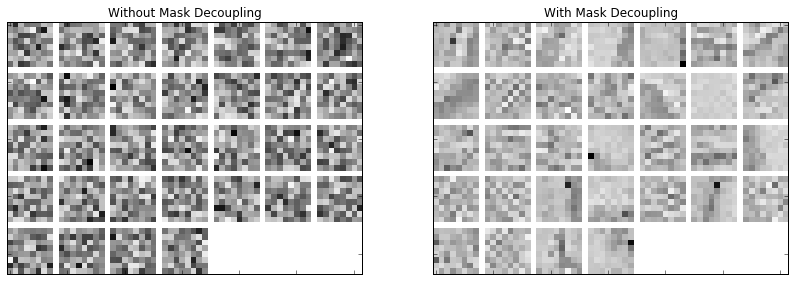

In [10]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D1.squeeze()), fig=fig,
            title='Without Mask Decoupling')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D2.squeeze()), fig=fig,
            title='With Mask Decoupling')
fig.show()

Display reference and training images.

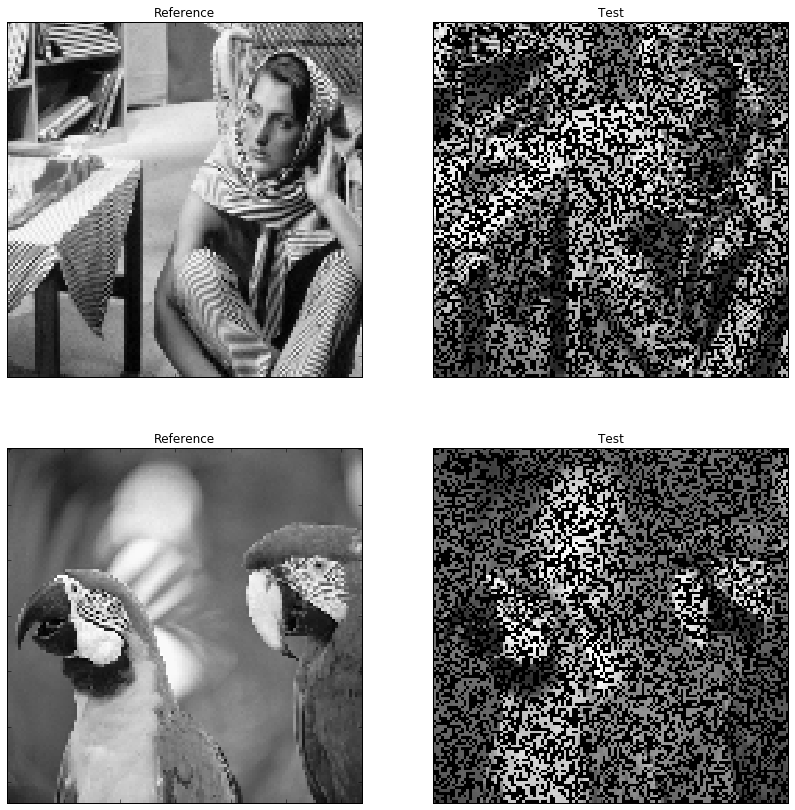

In [11]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(S[...,0], fig=fig, title='Reference')
plot.subplot(2, 2, 2)
plot.imview(Sw[...,0], fig=fig, title='Test')
plot.subplot(2, 2, 3)
plot.imview(S[...,1], fig=fig, title='Reference')
plot.subplot(2, 2, 4)
plot.imview(Sw[...,1], fig=fig, title='Test')
fig.show()

Compare reconstructed images.

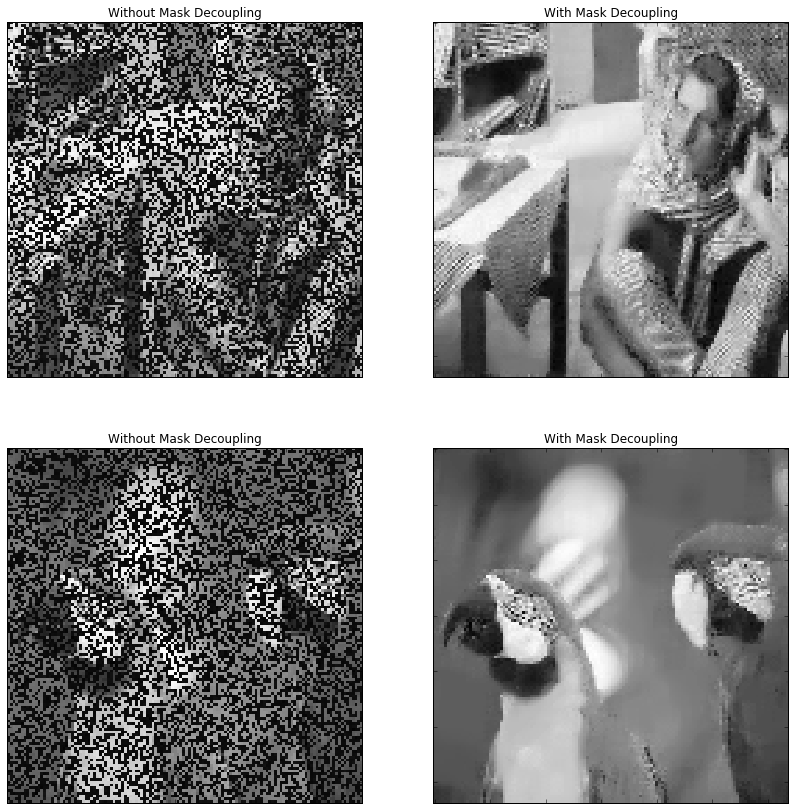

In [12]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sr1[...,0], fig=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 2)
plot.imview(sr2[...,0], fig=fig, title='With Mask Decoupling')
plot.subplot(2, 2, 3)
plot.imview(sr1[...,1], fig=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 4)
plot.imview(sr2[...,1], fig=fig, title='With Mask Decoupling')
fig.show()